In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from scipy.stats import boxcox, shapiro
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import pandas_gbq
# import 

# Import

In [2]:
# project_id = "inner-arch-419406"
# query = """
# SELECT * FROM URA_data_transformed.rentals_for_BI;
# """
# df = pandas_gbq.read_gbq(query, project_id=project_id, dialect="standard")

df = pd.read_csv("../data/rental_data_for_BI.csv")

df

,leaseDate,propertyType,district,noOfBedRoom,rent,street,x,y,project,refPeriod,psf75,median,psf25,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth
0,2021-07-03,Non-landed Properties,15,3,4200.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,1350.0,2021,3,7
1,2021-07-03,Non-landed Properties,15,2,3200.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,950.0,2021,3,7
2,2021-07-03,Non-landed Properties,15,3,5000.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,2150.0,2021,3,7
3,2021-07-03,Non-landed Properties,15,3,3500.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,1350.0,2021,3,7
4,2021-09-03,Non-landed Properties,15,4,5500.0,ELLIOT ROAD,38865.17182,32621.92134,ELLIOT AT THE EAST COAST,2021Q3,3.09,2.78,2.62,2650.0,2021,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281778,2023-12-04,Non-landed Properties,8,3,5500.0,PERUMAL ROAD,30477.87296,32796.58779,UPTOWN @ FARRER,2023Q4,7.43,7.15,6.49,650.0,2023,4,12
281779,2023-10-04,Non-landed Properties,8,2,4000.0,PERUMAL ROAD,30477.87296,32796.58779,UPTOWN @ FARRER,2023Q4,7.43,7.15,6.49,550.0,2023,4,10
281780,2023-10-04,Non-landed Properties,8,3,5300.0,PERUMAL ROAD,30477.87296,32796.58779,UPTOWN @ FARRER,2023Q4,7.43,7.15,6.49,750.0,2023,4,10
281781,2023-11-04,Non-landed Properties,8,2,4000.0,PERUMAL ROAD,30477.87296,32796.58779,UPTOWN @ FARRER,2023Q4,7.43,7.15,6.49,550.0,2023,4,11


# Split Data into Landed and Non-landed

In [3]:
landed = df[(df["propertyType"] != "Non-landed Properties") & (df["propertyType"] != "Executive Condominium")].reset_index(drop=True) # Terrace House, Detached House, Semi-Detached House
nonlanded = df[(df["propertyType"] == "Non-landed Properties") | (df["propertyType"] == "Executive Condominium")].reset_index(drop=True) # landed Properties, Executive Condominium

# One Hot Encoding

In [4]:
def encode_df(df):
    """ one hot encoding of features district and propertyType, first category dropped"""
    df['district'] = df['district'].astype('category')
    df['propertyType'] = df['propertyType'].astype('category')
    df = pd.get_dummies(df, columns=["district", "propertyType"], drop_first=True)
    return df

landed_encoded = encode_df(landed)
nonlanded_encoded = encode_df(nonlanded)

# Check null values

* Significant number of observations with missing IQR range for all propertyTypes. Difficult to impute values. Will not use IQR in modelling
* Very few ECs don't have noOfBedRoom. Impute with median
* Around 10% of Non-landed Properties don't have noOfBedRoom

In [5]:
print(f'total no. of Terrace House = {landed[landed["propertyType"] == "Terrace House"].shape[0]}')
print(f'total no. of Semi-Detached House = {landed[landed["propertyType"] == "Semi-Detached House"].shape[0]}')
print(f'total no. of Detached House = {landed[landed["propertyType"] == "Detached House"].shape[0]}')
print("\ncount of observations with missing IQR:")
landed[pd.isna(landed["median"])]["propertyType"].value_counts(dropna=False)

total no. of Terrace House = 9629
total no. of Semi-Detached House = 6505
total no. of Detached House = 4523

count of observations with missing IQR:


propertyType
Terrace House          9508
Semi-Detached House    6505
Detached House         4522
Name: count, dtype: int64

In [6]:
print(f'total no. of Non-landed Properties = {nonlanded[nonlanded["propertyType"] == "Non-landed Properties"].shape[0]}')
print(f'total no. of ECs = {nonlanded[nonlanded["propertyType"] == "Executive Condominium"].shape[0]}')
print("\ncount of observations with missing IQR:")
nonlanded[pd.isna(nonlanded["median"])]["propertyType"].value_counts(dropna=False)

total no. of Non-landed Properties = 255610
total no. of ECs = 5516

count of observations with missing IQR:


propertyType
Non-landed Properties    101092
Executive Condominium      5516
Name: count, dtype: int64

In [7]:
print("\ncount of observations with missing noOfBedRoom:")
landed[landed["noOfBedRoom"] != -1]["propertyType"].value_counts(dropna=False) # all landed properties don't have noOfBedRoom


count of observations with missing noOfBedRoom:


propertyType
Detached House         0
Semi-Detached House    0
Terrace House          0
Name: count, dtype: int64

In [8]:
print(f'total no. of Non-landed Properties = {nonlanded[nonlanded["propertyType"] == "Non-landed Properties"].shape[0]}')
print(f'total no. of ECs = {nonlanded[nonlanded["propertyType"] == "Executive Condominium"].shape[0]}')
print("\ncount of observations with missing noOfBedRoom:")
nonlanded[nonlanded["noOfBedRoom"] == -1]["propertyType"].value_counts(dropna=False) 

total no. of Non-landed Properties = 255610
total no. of ECs = 5516

count of observations with missing noOfBedRoom:


propertyType
Non-landed Properties    23896
Executive Condominium        5
Name: count, dtype: int64

# Data Imputation

In [9]:
EC_median_noOfBedRoom = np.median(nonlanded[(nonlanded["propertyType"] == "Executive Condominium") & (nonlanded["noOfBedRoom"] != -1)]["noOfBedRoom"])


In [10]:
nonlanded[(nonlanded["noOfBedRoom"] == -1) & (nonlanded[nonlanded["propertyType"] == "Non-landed Properties"])]

MemoryError: Unable to allocate 497. GiB for an array with shape (261126, 255610) and data type float64

# Functions

## VIF

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def get_VIF(features, df):
    # the independent variables set
    X = df[features]
    
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
    print(vif_data)#### Correlation Plot

## Correlation Plot

In [11]:
import seaborn as sns
def get_corr_plot(df):
    """all features must be numerical"""
    corr = df.corr()
    sns.set (rc = {'figure.figsize':(12,12)})
    sns.heatmap(corr, cmap='RdBu',annot=True, vmin=-1, vmax=1)


## Pairs Plot

In [12]:
def pairs(df):
    """all features must be numerical"""
    axes = pd.plotting.scatter_matrix(df, alpha=0.2, figsize = (25,25))
    plt.tight_layout()

## LRM

In [13]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_lrm(X_train_df: pd.DataFrame, y_train: pd.Series, X_test_df: pd.DataFrame, y_test: pd.Series, features: list, scaler=None):

    X_train_df = X_train_df.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test_df = X_test_df.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    if scaler:
        X_train = X_train_df[features]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = sm.add_constant(X_train_scaled)
        # y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))

        X_test = X_test_df[features]
        X_test_scaled = scaler.fit_transform(X_test)
        X_test_scaled = sm.add_constant(X_test_scaled)
        # y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))    
    else: # no scaling
        X_train_scaled = X_train_df[features]
        X_train_scaled = sm.add_constant(X_train_scaled)


        X_test_scaled = X_test_df[features]
        X_test_scaled = sm.add_constant(X_test_scaled)
    y_train_scaled = y_train
    y_test_scaled = y_test

    model = sm.OLS(y_train_scaled, X_train_scaled).fit()
    print(model.summary(xname=['const'] + features))

    # resid plot
    fitted_val = model.fittedvalues.copy()
    # true_val = y_train_scaled.copy().reshape(len(y_train_scaled,)) if scaler else y_train_scaled
    true_val = y_train_scaled
    residual = true_val - fitted_val
    result_df = pd.DataFrame({"fitted": fitted_val, "true": true_val, "resid": residual}) #"cid": X_train_df["CustomerID"],
    plt.figure(figsize=(4,4))
    plt.scatter(fitted_val, residual)
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.title("Residual against Predicted")
    plt.show()

    plt.figure(figsize=(4,4))
    plt.scatter(true_val, fitted_val)
    plt.xlabel("True Value")
    plt.ylabel("Fitted Value")
    plt.show()


    # testing
    pred_val = model.predict(X_test_scaled)
    # if scaler:
    #     print(f"MSE using testing data = {mean_squared_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    #     print(f"MAE using testing data = {mean_absolute_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    # else:
    print(f"MSE using testing data = {mean_squared_error(y_test_scaled, pred_val)}")
    print(f"RMSE using testing data= {mean_squared_error(y_test_scaled, pred_val, squared=False)}")
    print(f"MAE using testing data = {mean_absolute_error(y_test_scaled, pred_val)}")
    
    return {"model": model, "result_df": result_df}

### Backwards Selection

In [14]:
def backwards_selection(X, y):
    # Fit the initial model with all predictors
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    significance_threshold = 0.05

    # Perform backward selection
    while True:
        # Get the p-values of the predictor variables
        p_values = results.pvalues[1:]  # Exclude the constant term

        # Find the predictor with the highest p-value
        max_p_value = p_values.max()
        max_p_index = p_values.idxmax()

        # Check if the highest p-value exceeds the significance threshold
        if max_p_value > significance_threshold:
            # Remove the predictor with the highest p-value
            X = X.drop(max_p_index, axis=1)
            model = sm.OLS(y, X)
            results = model.fit()
        else:
            break

    # Final model after backward selection
    print(results.summary())

# Check Multicollinearity

In [15]:
landed

,leaseDate,propertyType,district,noOfBedRoom,rent,street,x,y,project,refPeriod,psf75,median,psf25,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth
0,2021-07-03,Terrace House,5,-1,5100.0,NEO PEE TECK LANE,20914.198897,30589.107079,LANDED HOUSING DEVELOPMENT,2021Q3,NaN,NaN,NaN,1750.0,2021,3,7
1,2021-08-03,Detached House,20,-1,5600.0,JALAN BERJAYA,29477.144479,37205.160471,THOMSON RISE ESTATE,2021Q3,NaN,NaN,NaN,5750.0,2021,3,8
2,2021-07-03,Detached House,10,-1,20000.0,NASSIM ROAD,26555.812930,32779.188480,LANDED HOUSING DEVELOPMENT,2021Q3,NaN,NaN,NaN,8000.0,2021,3,7
3,2021-08-03,Detached House,10,-1,25000.0,NASSIM ROAD,26555.812930,32779.188480,LANDED HOUSING DEVELOPMENT,2021Q3,NaN,NaN,NaN,8000.0,2021,3,8
4,2021-09-03,Detached House,10,-1,25000.0,NASSIM ROAD,26555.812930,32779.188480,LANDED HOUSING DEVELOPMENT,2021Q3,NaN,NaN,NaN,8000.0,2021,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20652,2023-10-04,Semi-Detached House,10,-1,6500.0,LANTANA AVENUE,23449.763137,34474.881884,LUCKY PARK,2023Q4,NaN,NaN,NaN,2250.0,2023,4,10
20653,2023-10-04,Semi-Detached House,10,-1,11500.0,SIXTH AVENUE,23507.964180,34065.242320,PALMS @ SIXTH AVENUE,2023Q4,NaN,NaN,NaN,5750.0,2023,4,10
20654,2023-12-04,Semi-Detached House,10,-1,14000.0,SIXTH AVENUE,23507.964180,34065.242320,PALMS @ SIXTH AVENUE,2023Q4,NaN,NaN,NaN,4750.0,2023,4,12
20655,2023-11-04,Semi-Detached House,21,-1,11000.0,JALAN KAKATUA,20625.167830,36223.353840,LANDED HOUSING DEVELOPMENT,2023Q4,NaN,NaN,NaN,2250.0,2023,4,11


In [22]:
numerical_cols = ['rent', 'noOfBedRoom', 
       'areaSqft_formatted',
       'leaseYear',  'leaseMonth', ]
get_VIF(numerical_cols, landed)

              feature           VIF
0                rent  1.702609e+00
1         noOfBedRoom  6.846153e+06
2  areaSqft_formatted  1.668408e+00
3           leaseYear  1.101324e+00
4          leaseMonth  1.004283e+00


In [21]:
numerical_cols = ['rent', 'noOfBedRoom', 
       'areaSqft_formatted',
       'leaseYear', 'leaseMonth', ]
get_VIF(numerical_cols, nonlanded)

              feature        VIF
0                rent   6.857262
1         noOfBedRoom   4.593436
2  areaSqft_formatted  11.181803
3           leaseYear   8.897588
4          leaseMonth   4.620090


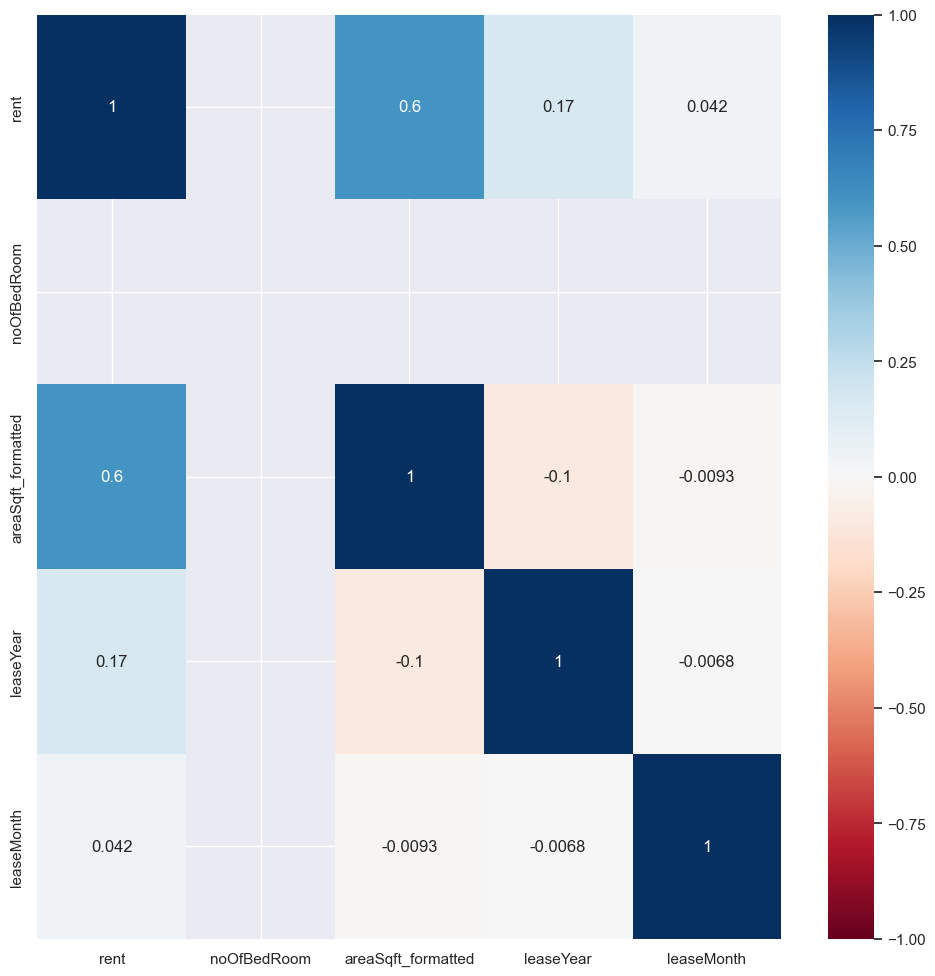

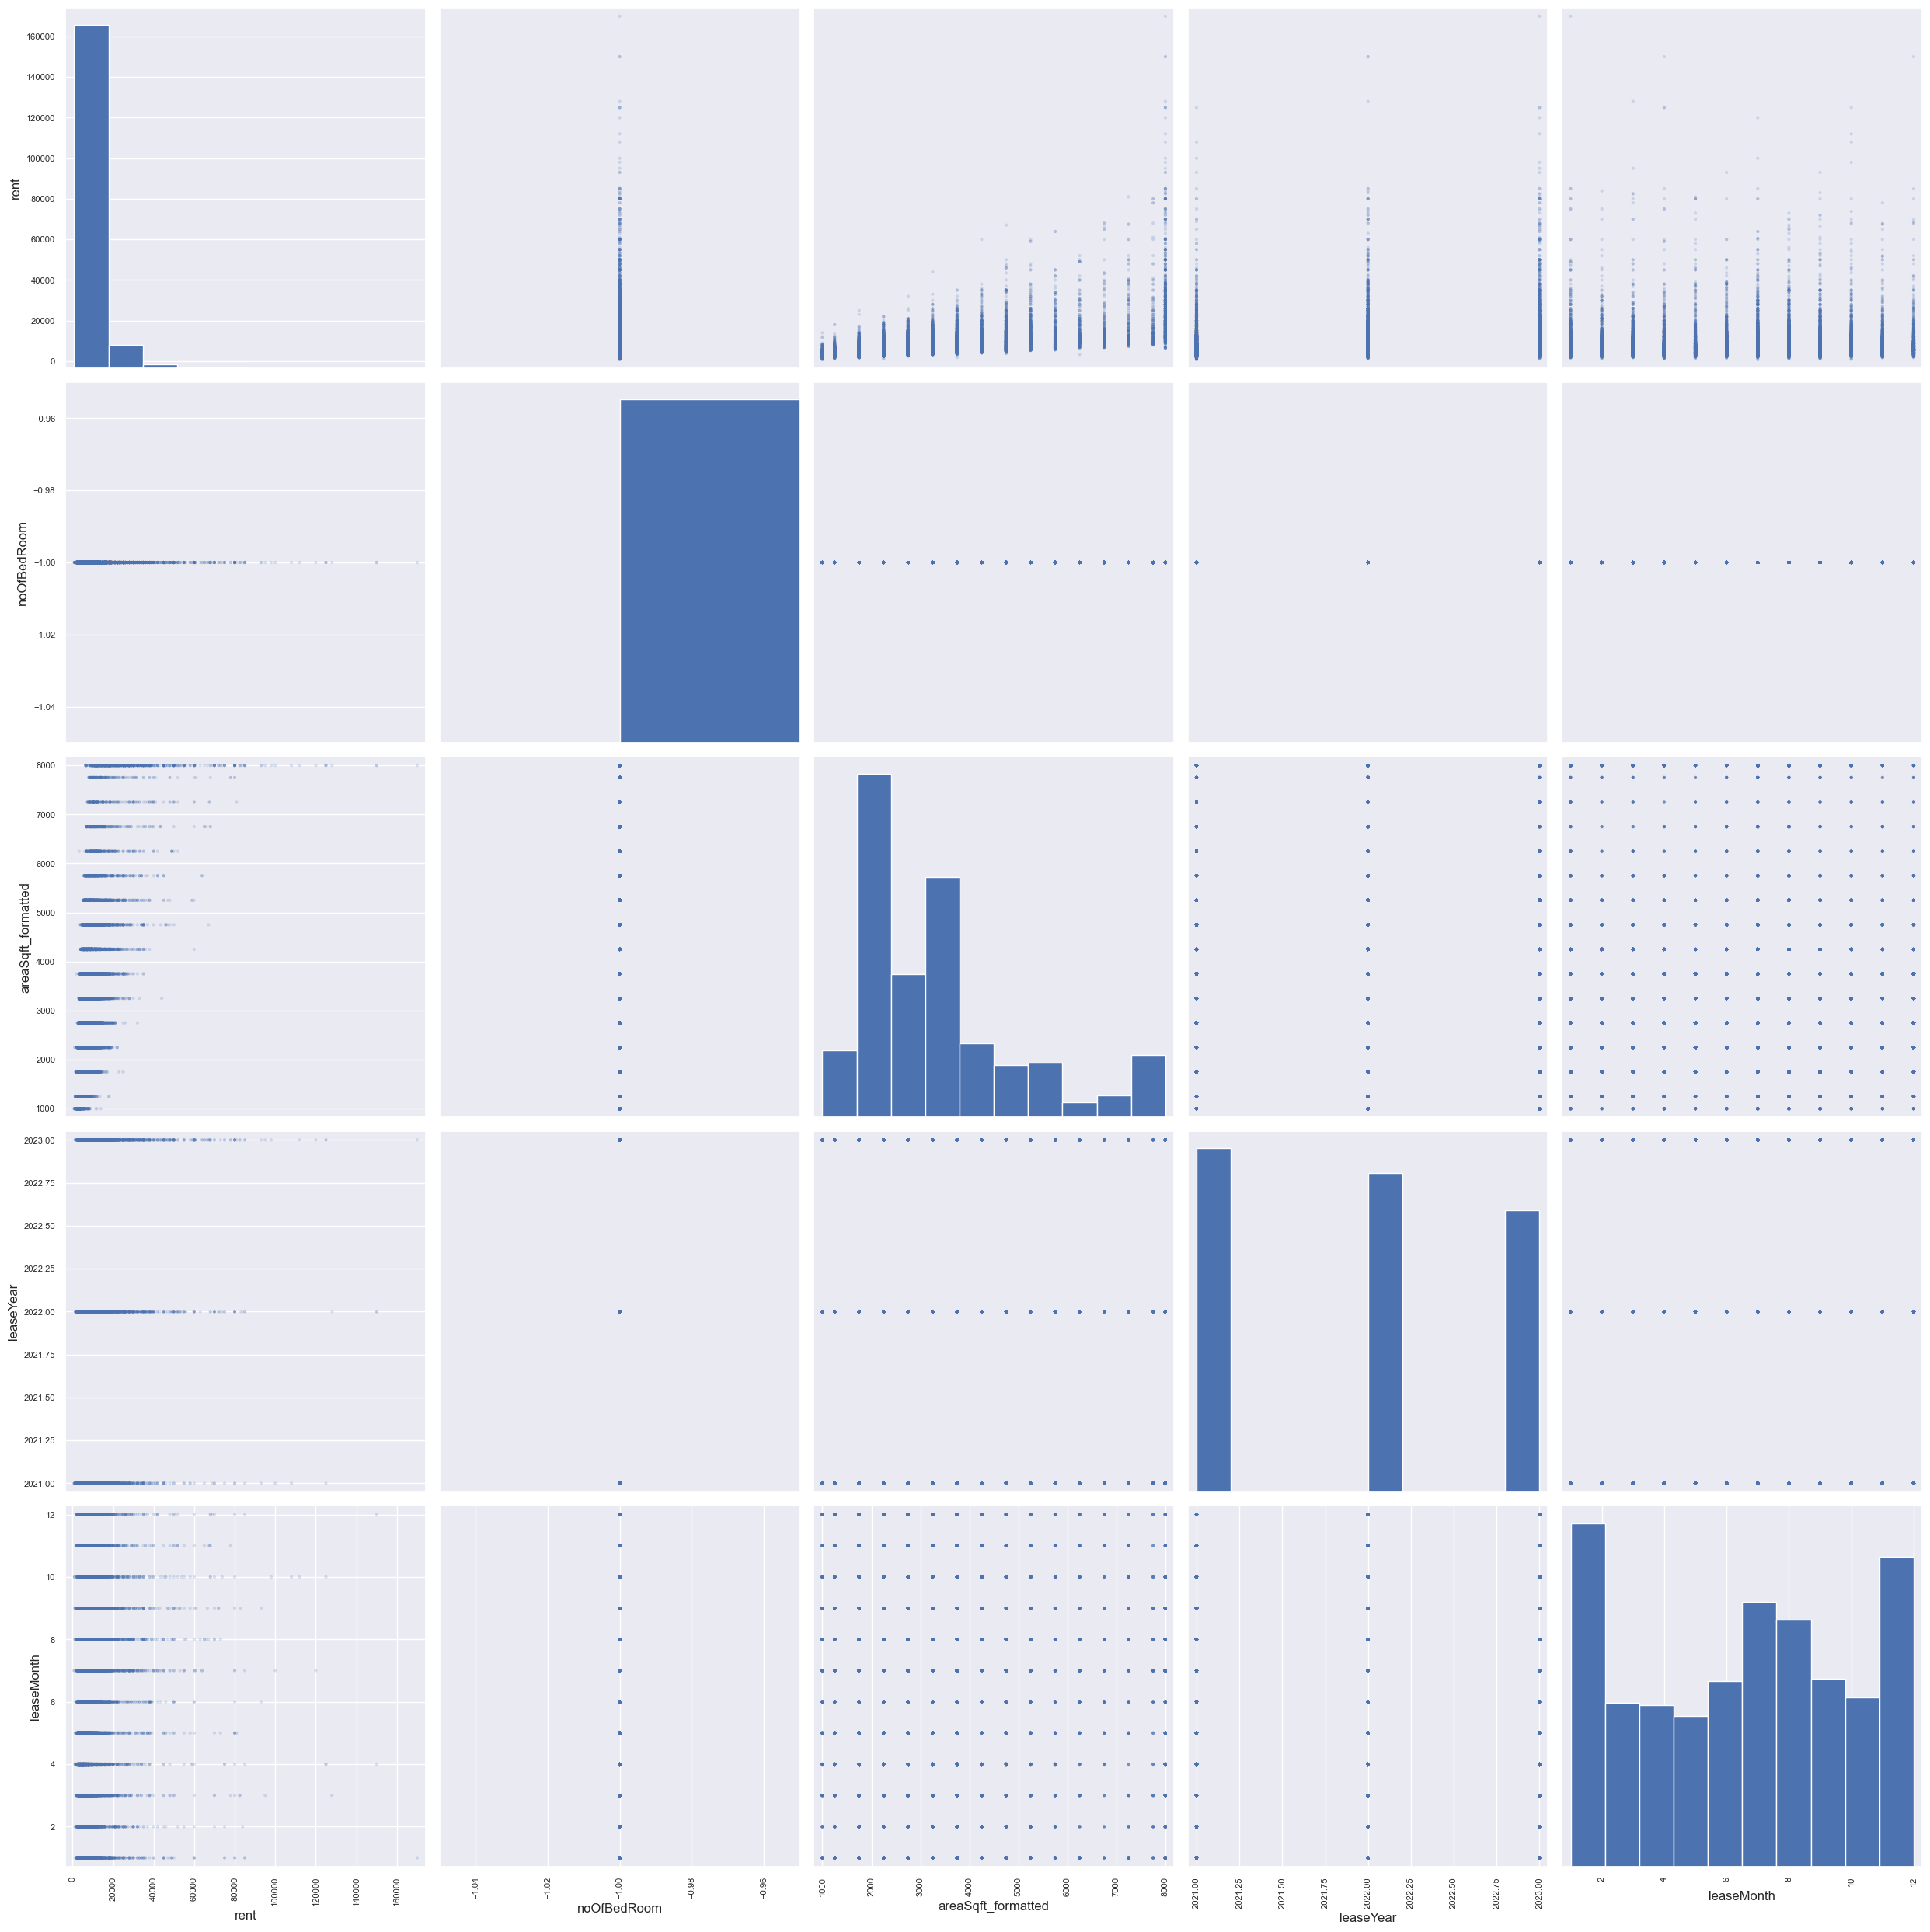

In [23]:
get_corr_plot(landed[numerical_cols])
pairs(landed[numerical_cols] )

# Modellling

In [24]:
print(landed_encoded.columns)

Index(['leaseDate', 'noOfBedRoom', 'rent', 'street', 'x', 'y', 'project',
       'refPeriod', 'psf75', 'median', 'psf25', 'areaSqft_formatted',
       'leaseYear', 'leaseQuarter', 'leaseMonth', 'district_2', 'district_3',
       'district_4', 'district_5', 'district_7', 'district_8', 'district_9',
       'district_10', 'district_11', 'district_12', 'district_13',
       'district_14', 'district_15', 'district_16', 'district_17',
       'district_18', 'district_19', 'district_20', 'district_21',
       'district_22', 'district_23', 'district_25', 'district_26',
       'district_27', 'district_28', 'propertyType_Semi-Detached House',
       'propertyType_Terrace House'],
      dtype='object')


In [26]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)

for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], landed_encoded["rent"], test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)
# get_VIF(X_features, X_train_df)
# get_corr_plot(X_train_df[features])

MissingDataError: exog contains inf or nans